# CarMDP Environment, which is provided for your convenience. You should not change code of this environment. This Jupyter notebook is prepared by Kui Wu 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import gym
import random

from gym import Env

class CarMDP(Env):
    """
    Car MDP with simple stochastic dynamics.
    The states are tuples with two elements:
        - a position index (i, j)
        - an integer from (0, 1, 2, 3) representing absolute orientation (see self.orientations in __init__ below)
    For example, the state
        s = (0, 1, 2)
    represents the car in the cell with indices (0, 1) and oriented to face the South.
    """
    def __init__(self, width, height, obstacles, goal_transition, initial_state, p_corr, base_reward=-0.01,
                 collision_reward=-5., goal_reward=10., stagnation_penalty=-0.01):
        self.width = width
        self.height = height
        self.grid_map = np.ones((width, height))
        for cell in obstacles:
            self.grid_map[cell[0], cell[1]] = 0.
        self.obstacles = obstacles
        self.orientations = {0: 'North', 1: 'East', 2: 'South', 3: 'West'}
        self.A = {0: 'Forward', 1: 'Left', 2: 'Right', 3: 'Brake'}
        self.goal_transition = goal_transition  # Tuple containing start and end state for the 'goal transition'

        self.p_corr = p_corr
        self.p_err = (1. - p_corr)/2.

        self.base_reward = base_reward
        self.collision_reward = collision_reward
        self.goal_reward = goal_reward
        self.stagnation_penalty = stagnation_penalty
        self.state_history = []
        self.action_history = []
        self.reward_history = []
        
        assert initial_state[0] >= 0 and initial_state[1] >= 0 and initial_state[0] < self.width and initial_state[1] < self.height and \
               initial_state[2] in self.orientations, "ERROR: initial state {:} is not valid.".format(init_state)
        self.state_history = [initial_state]
        self.action_history = []
        self.reward_history = []
        self.init_state=initial_state
    
       
    def reset(self):
        self.state_history = [self.init_state]
        self.action_history = []
        self.reward_history = []

    def is_collision(self, state):
        is_out_of_bounds = state[0] < 0 or state[0] >= self.width or state[1] < 0 or \
             state[1] >= self.height
        return is_out_of_bounds or (state[0], state[1]) in self.obstacles

    def transition_dynamics(self, state, action):
        assert not self.is_collision(state), "ERROR: can't take an action from a non-state."
        delta = 1
        orientation = state[2]

        if self.orientations[orientation] == 'North':
            left = (state[0] - delta, state[1] - delta)
            forward = (state[0], state[1] - delta)
            right = (state[0] + delta, state[1] - delta)
        elif self.orientations[orientation] == 'West':
            left = (state[0] - delta, state[1] + delta)
            forward = (state[0] - delta, state[1])
            right = (state[0] - delta, state[1] - delta)
        elif self.orientations[orientation] == 'South':
            left = (state[0] + delta, state[1] + delta)
            forward = (state[0], state[1] + delta)
            right = (state[0] - delta, state[1] + delta)
        elif self.orientations[orientation] == 'East':
            left = (state[0] + delta, state[1] - delta)
            forward = (state[0] + delta, state[1])
            right = (state[0] + delta, state[1] + delta)

        # p gives categorical distribution over (state, left, forward, right)
        if self.A[action] == 'Forward':
            p = np.array([0., self.p_err, self.p_corr, self.p_err])
        elif self.A[action] == 'Right':
            p = np.array([0., 0., 2.*self.p_err, self.p_corr])
        elif self.A[action] == 'Left':
            p = np.array([0., self.p_corr, 2. * self.p_err, 0.])
        elif self.A[action] == 'Brake':
            p = np.array([self.p_corr, 0., 2. * self.p_err, 0.])

        candidate_next_state_positions = (state, left, forward, right)
        next_state_position = candidate_next_state_positions[categorical_sample_index(p)]

        # Handle orientation dynamics (deterministic)
        new_orientation = orientation
        if self.A[action] == 'Right':
            new_orientation = (orientation + 1) % 4
        elif self.A[action] == 'Left':
            new_orientation = (orientation - 1) % 4

        return next_state_position[0], next_state_position[1], new_orientation

    
    def step(self, action):
        assert action in self.A, f"ERROR: action {action} not permitted"
        terminal = False
        current_state = self.state_history[-1] # -1 means the current element
        next_state = self.transition_dynamics(current_state, action)
        if self.is_collision(next_state):
            reward = self.collision_reward
            terminal = True
        elif (current_state[0], current_state[1]) == self.goal_transition[0] and \
                (next_state[0], next_state[1]) == self.goal_transition[1]:
            reward = self.goal_reward
            terminal = True  # TODO: allow multiple laps like this?
        elif current_state == next_state:
            reward = self.stagnation_penalty
            terminal = False
        else:
            reward = self.base_reward
            terminal = False

        self.state_history.append(next_state)
        self.reward_history.append(reward)
        self.action_history.append(action)

        return next_state, reward, terminal, []

    def render(self, title):
        self._plot_history(title)
    
    def _plot_history(self, title):
        """
        Plot the MDP's trajectory on the grid map.
        :param title:
        :return:
        """
        fig = plt.figure()
        plt.imshow(self.grid_map.T, cmap='gray')
        plt.grid()
        x = np.zeros(len(self.state_history))
        y = np.zeros(x.shape)
        for idx in range(len(x)):
            x[idx] = self.state_history[idx][0]
            y[idx] = self.state_history[idx][1]
            if self.state_history[idx][2] == 0:
                plt.arrow(x[idx], y[idx], 0., -0.25, width=0.1)
            elif self.state_history[idx][2] == 1:
                plt.arrow(x[idx], y[idx], 0.25, 0., width=0.1)
            elif self.state_history[idx][2] == 2:
                plt.arrow(x[idx], y[idx], 0., 0.25, width=0.1)
            else:
                plt.arrow(x[idx], y[idx], -0.25, 0., width=0.1)

        plt.plot(x, y, 'b-')  # Plot trajectory
        plt.xlim([-0.5, self.width + 0.5])
        plt.ylim([self.height + 0.5, -0.5])
        plt.title(title)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()
        return fig


def categorical_sample_index(p: np.ndarray) -> int:
    """
    Sample a categorical distribution.

    :param p: a categorical distribution's probability mass function (i.e., p[idx] is the probability of this function
              returning idx for an integer 0 <= idx < len(p)). I.e., np.sum(p) == 1 and p[idx] >= 0 for 0<=idx<len(p).
    :return: index of a sample weighted by the categorical distribution described by p
    """
    P = np.cumsum(p)
    sample = np.random.rand()
    return np.argmax(P > sample)



# Below is the skeleton code of your agent. Your solution should be filled here.  

In [2]:
from collections import defaultdict
class ReinforcementLearningAgent:
    """
    Your implementation of a reinforcement learning agent.
    Feel free to add additional methods and attributes.
    """
    def __init__(self, discount=0.9, epsilon=0.2, alpha=0.25):
        ### STUDENT CODE GOES HERE
        # Set any parameters
        # You can add arguments to __init__, so log as they have default values (e.g., epsilon=0.1)
        self.state_history = []
        self.action_history = []
        self.epsilon = epsilon
        self.discount = discount
        self.alpha = alpha
        self.Q = defaultdict(lambda: defaultdict(lambda: 0))
        self.env_actions = lambda s : range(4) 
        pass
    
    def set_q(self, state, action, v):
        self.Q[state][action] = v
    
    def get_q(self, state, action):
        return self.Q[state][action]
    
    def td_update(self, state, action, reward, next_state, next_action, terminal):
        if not terminal:
            td = reward + self.discount * self.get_q(next_state, next_action) - self.get_q(state, action)
        else:
            td = reward - self.get_q (state, action)
        
        v = self.get_q(state, action) + self.alpha * td
        self.set_q(state, action, v)

    def argmax_a(self, state):
        acts = self.env_actions(state)
        max_action = []
        max_q = float('-inf')

        for a in acts:
            QV = self.get_q(state, a)
            if QV > max_q:
                max_action = [a]
                max_q = QV
            elif QV == max_q:
                max_action.append(a)
        
        return np.random.choice(np.array(max_action))

    def reset(self, init_state) -> int:
        """
        Called at the start of each episode.

        :param init_state:
        :return: first action to take.
        """
        self.state_history.append(init_state)
        next_action = self.choose_action(init_state)
        self.action_history.append(next_action)
        ### STUDENT CODE GOES HERE
        return next_action # Random policy (CHANGE THIS)
    
    def choose_action(self, state):
        acts = self.env_actions(state)

        if len(acts) == 0:
            return None
        if np.random.random() < self.epsilon:
            a = np.random.choice(acts)
            return a
        else:
            a = self.argmax_a(state)
            return a

    def next_action(self, reward: float, state: int, terminal: bool) -> int:
        """
        Called during each time step of a reinforcement learning episode

        :param reward: reward resulting from the last time step's action
        :param state: state resulting from the last time step's action
        :param terminal: bool indicating whether state is a terminal state
        :return: next action to take
        """
        next_action = self.choose_action(state)
        self.td_update(self.state_history[-1], self.action_history[-1], reward, state, next_action, terminal)
        self.state_history.append(state)
        self.action_history.append(next_action)
        ### STUDENT CODE GOES HERE
        # Produce the next action to take in an episode as a function of the observed reward and state
        # You may find it useful to track past actions, states, and rewards
        # Additionally, algorithms that learn during an episode (e.g., temporal difference) may find use for this method
        return next_action  # Random policy (CHANGE THIS)

    def finish_episode(self):
        """
        Called at the end of each episode.
        :return: nothing
        """
        ### STUDENT CODE GOES HERE
        # Algorithms that learn from an entire episode (e.g., Monte Carlo) may find a use for this method
        pass


# Below is the sample test code. In the final print out you need to print out the correct policy name (It is random so far). Note that since this is a model-free solution, we will use a different test environment (i.e., the locations and the sizes of barriers are different) to test your code. 

testing with: epsilon=0.01 and alpha=0.25
()
testing with: epsilon=0.01 and alpha=0.50
()
testing with: epsilon=0.01 and alpha=0.75
()
testing with: epsilon=0.05 and alpha=0.25
()
testing with: epsilon=0.05 and alpha=0.50
()
testing with: epsilon=0.05 and alpha=0.75
()
testing with: epsilon=0.10 and alpha=0.25
()
testing with: epsilon=0.10 and alpha=0.50
()
testing with: epsilon=0.10 and alpha=0.75
()


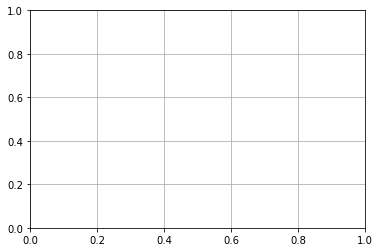

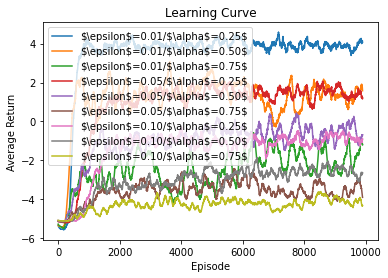

In [4]:
def test_rl_algorithm(rl_agent, car_mdp, initial_state, n_episodes=10000, n_plot=np.inf):
    """
    Code that will be used to test your implementation of ReinforcementLearningAgent.
    As you can see, you are responsible for implementing three methods in ReinforcementLearningAgent:
        - reset (called at the start of every episode)
        - next_action (called at every time step of an episode)
        - finish_episode (called at the end of each episode)

    :param rl_agent: an instance of your ReinforcementLearningAgent class
    :param car_mdp: an instance of CarMDP
    :param init_state: the initial state
    :param n_episodes: number of episodes to use for this test
    :param n_plot: display a plot every n_plot episodes
    :return:
    """
    returns = []
    for episode in range(n_episodes):
        G = 0.  # Keep track of the returns for this episode (discount factor gamma=1)
        # Re-initialize the MDP and the RL agent
        car_mdp.reset();
        action = rl_agent.reset(initial_state)
        terminal = False
        while not terminal:  # Loop until a terminal state is reached
            next_state, reward, terminal, [] = car_mdp.step(action)
            G += reward
            action = rl_agent.next_action(reward, next_state, terminal)
        rl_agent.finish_episode()
        returns += [G]

        # Plot the trajectory every n_plot episodes
        if episode % n_plot == 0 and episode > 0:
            car_mdp.render('State History ' + str(episode + 1))

    return returns


if __name__ == '__main__':

    # Size of the CarMDP map (any cell outside of this rectangle is a terminal state)
    width = 9
    height = 6
    initial_state = (0, 0, 2)  # Top left corner (0, 0), facing "Down" (2)
    obstacles = [(2, 2), (2, 3), (3, 2), (3, 3),  # Cells filled with obstacles are terminal states
                 (5, 2), (5, 3), (6, 2), (6, 3),
                 (1, 1), (1, 2)]
    goal_transition = ((1, 0), (0, 0))  # Transitioning from cell (1, 0) to cell (0, 0) terminates and gives a reward
    p_corr = 0.95  # Probability of actions working as intended
    
  # Create environment
    car_mdp = CarMDP(width, height, obstacles, goal_transition, initial_state, p_corr=p_corr)
  
 # Create RL agent. # You must complete this class in your solution, it is random policy right now
 
    rl_agent = ReinforcementLearningAgent()  
    
   
    #student_returns = test_rl_algorithm(rl_agent, car_mdp, initial_state, n_episodes=50000, n_plot=4999)

    # Example plot. You need to change it according to the assignment requirements. 
    n_runs = 20
    n_episodes = 10000
    epsilon = [0.01, 0.05, 0.1]
    alpha = [0.25, 0.5, 0.75]
    discount = [0.9]
    tests = []
    avg_returns = []
    test = []
    final_graph = []
    plt.grid()
    plt.figure()
    plt.title('Learning Curve')
    plt.xlabel('Episode')
    plt.ylabel('Average Return')
    for e in epsilon:
        for a in alpha:
            for d in discount:
                returns = np.zeros((n_runs, n_episodes))
                print("testing with: epsilon={:.2f} and alpha={:.2f}".format(e, a))
                for run in range(n_runs):
                    rl_agentnew = ReinforcementLearningAgent(d, e, a)
                    returns[run, :] = test_rl_algorithm(rl_agentnew, car_mdp, initial_state, n_episodes=n_episodes)
                test = "e,a,d = {},{},{}".format(e, a, d)
                tests.append(test)
                mean_re = np.mean(np.mean(returns, axis=0))
                print(mean_re.shape)
                avg_returns.append(mean_re)

                # Plot one curve like this for each parameter setting - the template code for ReinforcementLearningAgent just
                # returns a random action, so this example curve will just be noise. When your method is working, the mean return
                # should increase as the number of episodes increases. Feel free to change the rolling average width
                rolling_average_width = 100
                # Compute the mean (over n_runs) for each episode
                mean_return = np.mean(returns, axis=0)
                # Compute the rolling average (over episodes) to smooth out the curve
                rolling_average_mean_return = np.convolve(mean_return, np.ones(rolling_average_width), 'valid')/rolling_average_width
                final_graph.append(rolling_average_mean_return)
                plt.plot(rolling_average_mean_return, label=r"$\epsilon$={:.2f}/$ | $\alpha$={:.2f}".format(e, a))  # Plot the smoothed average return for each episode over n_runs
          
    plt.legend()
    plt.show()
